# Hello, PyTorch! -- MNIST Handwritten Digits

- https://en.wikipedia.org/wiki/MNIST_database

# Load Datasets

In [ ]:
import torch
from torchvision import datasets, transforms

In [ ]:
x = datasets.MNIST('data')
x[0]

In [4]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [5]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

dataset2 = datasets.MNIST('data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1000)

Failed to download (trying next):
HTTP Error 403: Forbidden



4.0%

100.0%


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [6]:
i, x = next(enumerate(train_loader))
x[0].shape

torch.Size([64, 1, 28, 28])

# View Image

In [7]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

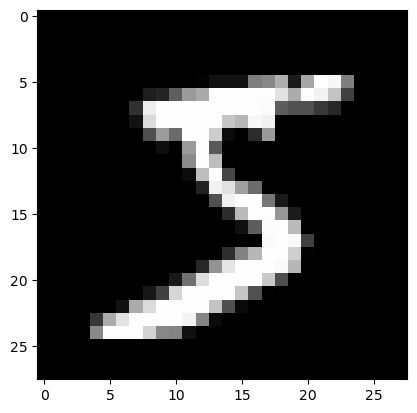

In [8]:
i, x = next(enumerate(train_loader))
x2 = np.squeeze(x[0][0])
plt.imshow(x2, cmap='gray')

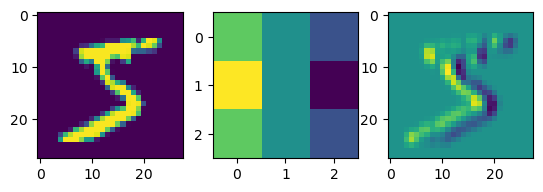

In [9]:
kernel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
y = scipy.ndimage.convolve(x2, kernel)

fig, axes = plt.subplots(1,3)
axes[0].imshow(x2)
axes[1].imshow(kernel)
axes[2].imshow(y)

# Create Network

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [12]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
summary(network, input_size=(1,28,28))

/opt/anaconda3/envs/pytorch/lib/python3.13/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(
/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_41641/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [10, 24, 24]              260
├─Conv2d: 1-2                            [20, 8, 8]                5,020
├─Dropout2d: 1-3                         [20, 8, 8]                --
├─Linear: 1-4                            [1, 50]                   16,050
├─Linear: 1-5                            [1, 10]                   510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.88
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.09
Estimated Total Size (MB): 0.15

# Visualize Weights

In [13]:
def visualize():
    i, x = next(enumerate(test_loader))
    x2 = np.squeeze(x[0][0])
    weights = network.conv1.weight.data
    
    fig, axes = plt.subplots(10,2)
    for i in range(10):
        weights_np = np.squeeze(weights.numpy()[i,0,:,:])
        axes[i,0].imshow(weights_np)
        axes[i,1].imshow(scipy.ndimage.convolve(x2, weights_np))

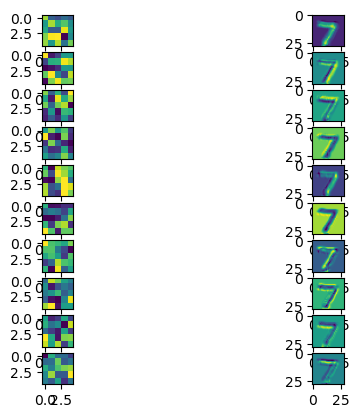

In [14]:
visualize()

# Predict Using Network

In [15]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [16]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_41641/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([4, 7, 4, 7, 2])

# First Test and Train

In [17]:
def test():
  network.eval()
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  print('Test accuracy: {:.0f}%\n'.format(100. * correct / len(test_loader.dataset)))

In [18]:
test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_41641/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Test accuracy: 5%



In [19]:
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
def train():
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 100 == 0:
      print('Train loss: {:.6f}'.format(loss.item()))

In [20]:
train()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_41641/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.352517
Train loss: 1.981395
Train loss: 1.039548
Train loss: 1.117152
Train loss: 0.723883
Train loss: 0.666173
Train loss: 0.419511
Train loss: 0.517813
Train loss: 0.542374
Train loss: 0.606651


# Train Network

In [21]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_41641/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.331265
Train loss: 2.076123
Train loss: 1.048560
Train loss: 0.836191
Train loss: 0.794817
Train loss: 0.657933
Train loss: 0.675035
Train loss: 0.524517
Train loss: 0.549639
Train loss: 0.380257
Test accuracy: 94%

Train loss: 0.368639
Train loss: 0.467009
Train loss: 0.401295
Train loss: 0.396471
Train loss: 0.427765
Train loss: 0.283429
Train loss: 0.392709
Train loss: 0.530130
Train loss: 0.395265
Train loss: 0.405604
Test accuracy: 96%

Train loss: 0.331727
Train loss: 0.194844
Train loss: 0.319826
Train loss: 0.353254
Train loss: 0.207535
Train loss: 0.314626
Train loss: 0.413262
Train loss: 0.430529
Train loss: 0.460433
Train loss: 0.415370
Test accuracy: 97%

Train loss: 0.190086
Train loss: 0.296512
Train loss: 0.174126
Train loss: 0.264493
Train loss: 0.105019
Train loss: 0.217007
Train loss: 0.236892
Train loss: 0.326305
Train loss: 0.228550
Train loss: 0.464447
Test accuracy: 97%

Train loss: 0.194386
Train loss: 0.273997
Train loss: 0.269197
Train loss: 0.443

# Inspect Network

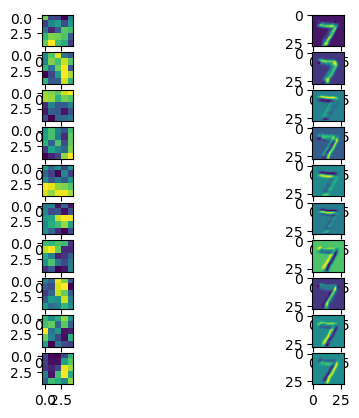

In [22]:
visualize()

In [23]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [24]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_41641/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([5, 0, 4, 1, 9])

# How Much Data?

- What is the accuracy using 60,000 images? 30,000? 6,000? 3,000? 600?
- How do the weights looks different when trained with 60,000 vs 600?

In [25]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(30000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [26]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_41641/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.351184
Train loss: 1.756168
Train loss: 0.949964
Train loss: 0.833055
Train loss: 0.738541
Test accuracy: 91%

Train loss: 0.634164
Train loss: 0.448729
Train loss: 0.485054
Train loss: 0.569018
Train loss: 0.482302
Test accuracy: 94%

Train loss: 0.284497
Train loss: 0.391266
Train loss: 0.330563
Train loss: 0.517974
Train loss: 0.283264
Test accuracy: 96%

Train loss: 0.358728
Train loss: 0.273109
Train loss: 0.288292
Train loss: 0.327077
Train loss: 0.338089
Test accuracy: 96%

Train loss: 0.318022
Train loss: 0.321081
Train loss: 0.283539
Train loss: 0.383685
Train loss: 0.241001
Test accuracy: 97%



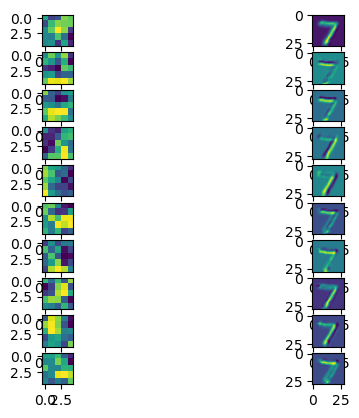

In [27]:
visualize()

Exercise 1
Question 1a: What is the accuracy using 60,000 images? 30,000? 6,000? 3,000? 600?

In [28]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(60000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [29]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_41641/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.328576
Train loss: 1.772752
Train loss: 1.061910
Train loss: 0.904452
Train loss: 0.631199
Train loss: 0.628224
Train loss: 0.620055
Train loss: 0.647576
Train loss: 0.558173
Train loss: 0.593586
Test accuracy: 94%

Train loss: 0.463970
Train loss: 0.477321
Train loss: 0.344531
Train loss: 0.414850
Train loss: 0.319256
Train loss: 0.489798
Train loss: 0.288333
Train loss: 0.420088
Train loss: 0.581416
Train loss: 0.516134
Test accuracy: 96%

Train loss: 0.277404
Train loss: 0.341067
Train loss: 0.248923
Train loss: 0.401785
Train loss: 0.252573
Train loss: 0.341508
Train loss: 0.250029
Train loss: 0.318808
Train loss: 0.457920
Train loss: 0.450407
Test accuracy: 97%

Train loss: 0.185483
Train loss: 0.306212
Train loss: 0.192559
Train loss: 0.297386
Train loss: 0.313953
Train loss: 0.255761
Train loss: 0.211697
Train loss: 0.343548
Train loss: 0.328889
Train loss: 0.254083
Test accuracy: 97%

Train loss: 0.180277
Train loss: 0.319321
Train loss: 0.160360
Train loss: 0.264

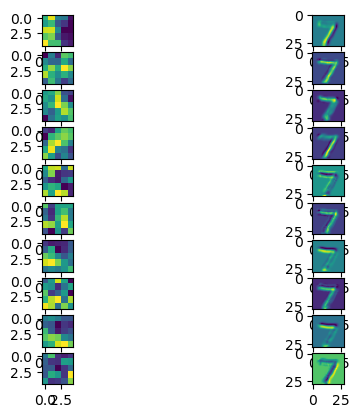

In [30]:
visualize()

The accuracy of using 60,000 images is 98%.

In [31]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(30000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [32]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_41641/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.332037
Train loss: 2.034653
Train loss: 1.311925
Train loss: 0.779870
Train loss: 0.662011
Test accuracy: 90%

Train loss: 0.644869
Train loss: 0.485134
Train loss: 0.476463
Train loss: 0.452908
Train loss: 0.413794
Test accuracy: 94%

Train loss: 0.563514
Train loss: 0.423340
Train loss: 0.407978
Train loss: 0.540309
Train loss: 0.393175
Test accuracy: 96%

Train loss: 0.336691
Train loss: 0.259145
Train loss: 0.299951
Train loss: 0.363639
Train loss: 0.357753
Test accuracy: 96%

Train loss: 0.355387
Train loss: 0.360326
Train loss: 0.248719
Train loss: 0.409259
Train loss: 0.324179
Test accuracy: 97%



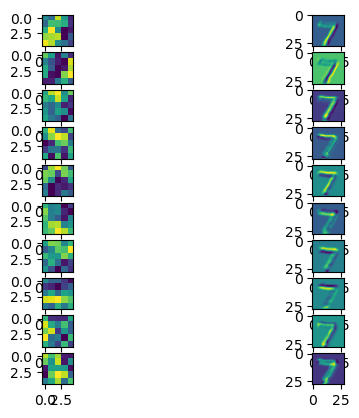

In [33]:
visualize()

The accuracy of using 30,000 images is 97%.

In [34]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(6000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [35]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_41641/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.320471
Test accuracy: 69%

Train loss: 1.807733
Test accuracy: 80%

Train loss: 1.086388
Test accuracy: 86%

Train loss: 0.995955
Test accuracy: 89%

Train loss: 0.834231
Test accuracy: 90%



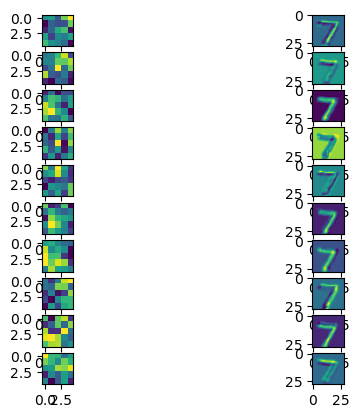

In [36]:
visualize()

The accuracy of using 6000 images is 90%.

In [40]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(3000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [41]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_41641/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.347446
Test accuracy: 15%

Train loss: 2.254171
Test accuracy: 59%

Train loss: 2.096481
Test accuracy: 75%

Train loss: 1.543570
Test accuracy: 83%

Train loss: 0.970847
Test accuracy: 87%



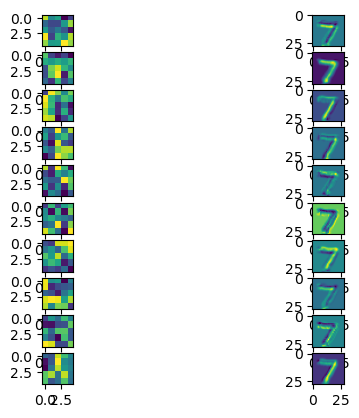

In [42]:
visualize()

The accuracy of using 3000 images is 87%.

In [43]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(600))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [44]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_41641/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.358449
Test accuracy: 9%

Train loss: 2.318075
Test accuracy: 11%

Train loss: 2.288510
Test accuracy: 13%

Train loss: 2.268256
Test accuracy: 17%

Train loss: 2.281226
Test accuracy: 20%



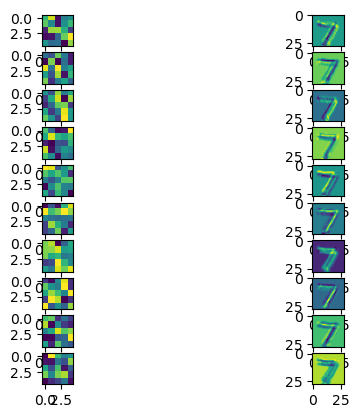

In [45]:
visualize()

The accuracy of using 600 images is 20%.

Question 1b:
When trained with 60000, the weights look very accurate and defined. When trained with 600, the weights look less accurate and poorly defined.